In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
plt.rcParams['mathtext.fontset'] = 'stix'

from sgoopT import stationary, mu_factor, eigenval, sg_transmat, sgap
from cmap1dT import SgoopDistance

# Variables

In [2]:
# data:
filename={}
x={}
y={}
hbias={} 
xbias={} 
ybias={}
weights={}
hist={}
mids={}
prob={}
freeE={}

# MD parameters:
beta=2.5
Rout=100  # (unit: steps/lines)

# metaD parameters:
stride={}
wbias={}
delta_beta={}

# SGOOP parameters:
rc_bin={}
wells={}
th={}
coeff={}
rc={}
pi={}
MU={}
S={}
E={}
binedges={}


# First SGOOP

### Read trajectory files

In [3]:
# In order to obtain a better estimate of free energy from biased simulations, here we have 5 independent runs (folders)
# along two orthgonal RCs. For each independent runs we start the simulations twice from 4 metastable states (files) in the
# model potential.
MAX_ROWS=15000
FOLDERS=np.arange(5)
NUM_FILES=8

# Read unbiased data:
filename['unbiased']='./DATA4s/w1_2/unbiased/xvyw1beta2.5gammax1.0gammay1.0epsln1.0sgma1.0A2.5x01.122w1.2B1.0a1.0_h0.01.txt'
x['unbiased'], y['unbiased'] = np.loadtxt(filename['unbiased'], unpack=True, usecols=(0,1), skiprows=1, max_rows=500000)

# Read biased data:
for k in FOLDERS:
    for i in range(NUM_FILES):
        filename['biased_1']='./DATA4s/w1_2/biased1/h0_4_w0_3_db0_5_stride200_cx0_891_cy0_454({})/xvyw{}beta2.5gammax1.0gammay1.0epsln1.0sgma1.0A2.5x01.122w1.2B1.0a1.0_h0.01.txt'.format(k+1,i+1)
        if i==0 and k==FOLDERS[0]:
            x['1'], y['1'], hbias['1'], xbias['1'], ybias['1'] = np.loadtxt(filename['biased_1'], unpack=True, usecols=(0,1, 6,7,8), skiprows=1, max_rows=MAX_ROWS)
        else:
            x_i, y_i, hbias_i, xbias_i, ybias_i = np.loadtxt(filename['biased_1'], unpack=True, usecols=(0,1, 6,7,8), skiprows=1, max_rows=MAX_ROWS)
            x['1']=np.append(x['1'], x_i)
            y['1']=np.append(y['1'], y_i)
            hbias['1']=np.append(hbias['1'], hbias_i)
            xbias['1']=np.append(xbias['1'], xbias_i)
            ybias['1']=np.append(ybias['1'],ybias_i)

    # Read biased data:
    for i in range(NUM_FILES):
        filename['biased_1']='./DATA4s/w1_2/biased1/h0_4_w0_3_db0_5_stride200_cx-0_454_cy0_891({})/xvyw{}beta2.5gammax1.0gammay1.0epsln1.0sgma1.0A2.5x01.122w1.2B1.0a1.0_h0.01.txt'.format(k+1,i+1)
        x_i, y_i, hbias_i, xbias_i, ybias_i = np.loadtxt(filename['biased_1'], unpack=True, usecols=(0,1, 6,7,8), skiprows=1, max_rows=MAX_ROWS)
        x['1']=np.append(x['1'], x_i)
        y['1']=np.append(y['1'], y_i)
        hbias['1']=np.append(hbias['1'], hbias_i)
        xbias['1']=np.append(xbias['1'], xbias_i)
        ybias['1']=np.append(ybias['1'],ybias_i)

### Read reweighting factors

In [4]:
for k in FOLDERS:
    for i in range(NUM_FILES):
        filename['weights']='./DATA4s/w1_2/biased1/h0_4_w0_3_db0_5_stride200_cx0_891_cy0_454({})/weights{}_biased1.txt'.format(k+1,i+1)
        if i==0 and k==FOLDERS[0]:
            weights['1']=np.loadtxt(filename['weights'], max_rows=MAX_ROWS)
        else:
            weights['1']=np.append(weights['1'], np.loadtxt(filename['weights'], max_rows=MAX_ROWS))

    for i in range(NUM_FILES):
        filename['weights']='./DATA4s/w1_2/biased1/h0_4_w0_3_db0_5_stride200_cx-0_454_cy0_891({})/weights{}_biased1.txt'.format(k+1,i+1)
        weights['1']=np.append(weights['1'], np.loadtxt(filename['weights'], max_rows=MAX_ROWS))

### Spectral gap optimization: Find optimal RC $\chi^{(1)}$

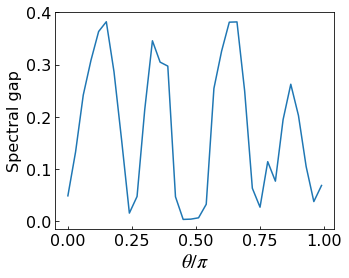

Maximal sgap at 
th=0.15pi
  =27.0(degrees)


In [5]:
# parameters:
rc_bin['1']=30
wells['1']=4
num_pt=34
rc_interval=0.03
coeff['i']=np.zeros(2)

# data:
sgap_arr=np.zeros(num_pt)
i_arr=np.arange(num_pt)
for i in i_arr:
    th['i'] = np.pi*i*rc_interval
    coeff['i'][0], coeff['i'][1] = np.cos(th['i']), np.sin(th['i'])
    rc['unbiased'] = coeff['i'][0]*x['unbiased'] + coeff['i'][1]*y['unbiased']
    rc['i'] = coeff['i'][0]*x['1'] + coeff['i'][1]*y['1']
    
    pi['i'], _ = stationary(rc['i'], rc_bin=rc_bin['1'], weights=weights['1'])
    MU['i'] = mu_factor(rc['unbiased'], pi['i'], rc_bin=rc_bin['1'], max_d=1)
    S['i'] = sg_transmat(rc_bin['1'], pi['i'], MU['i'], max_d=1)
    sgap_arr[i] = sgap(S['i'], wells['1'])
    
# Plottings:
fig, ax=plt.subplots(figsize=(5,4))
ax.plot(rc_interval*i_arr, sgap_arr)
ax.tick_params(which='major', axis='both', direction='in', labelsize=16)
ax.set_xlabel('$\\theta/\pi$', size=20)
ax.set_ylabel('Spectral gap', size=16)

plt.show()

print('Maximal sgap at \nth={}pi\n  ={}(degrees)'.format(rc_interval*np.argmax(sgap_arr), rc_interval*np.argmax(sgap_arr)*180))

### Exp(eigenvalues) and 0th eigenvectors of MaxCal-based rate matrix for optimal RC $\chi^{(1)}$

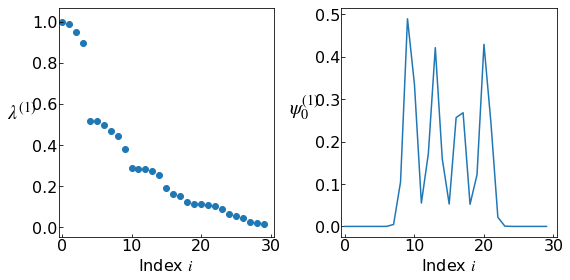

In [6]:
# parameters:
rc_bin['1']=30
th['1']=0.15*np.pi
coeff['1']=np.zeros(2)
coeff['1'][0], coeff['1'][1] = np.cos(th['1']), np.sin(th['1'])

# data:
rc['unbiased'] = coeff['1'][0]*x['unbiased'] + coeff['1'][1]*y['unbiased']
rc['1'] = coeff['1'][0]*x['1'] + coeff['1'][1]*y['1']
pi['1'], binedges['1'] = stationary(rc['1'], rc_bin=rc_bin['1'], weights=weights['1'])
MU['1'] = mu_factor(rc['unbiased'], pi['1'], rc_bin=rc_bin['1'], max_d=1)
S['1'] = sg_transmat(rc_bin['1'], pi['1'], MU['1'], max_d=1)
E['1'] = eigenval(S['1'])
eval1, exp_eval1, evec1 = E['1']
rate1 = -eval1

# Plottings:
fig, ax=plt.subplots(figsize=(8,4), nrows=1, ncols=2)

ax[0].scatter(np.arange(exp_eval1.shape[0]), exp_eval1)
ax[1].plot(evec1[:,0])

ax[0].tick_params(which='major', axis='both', direction='in', labelsize=16, pad=1)
ax[0].set_xlabel('Index $i$', size=16)
ax[0].set_ylabel('$\lambda^{(1)}$', size=20).set_rotation(0)
ax[0].yaxis.set_label_coords(-0.17, 0.5)
ax[0].set_xlim(-0.5,rc_bin['1']+0.5)

ax[1].tick_params(which='major', axis='both', direction='in', labelsize=16, pad=1)
ax[1].set_xlabel('Index $i$', size=16)
ax[1].set_ylabel('$\psi^{(1)}_0$', size=20).set_rotation(0)
ax[1].yaxis.set_label_coords(-0.17, 0.5)
ax[1].set_xlim(-0.5,rc_bin['1']+0.5)

fig.tight_layout()

plt.show()


# Second SGOOP

### Read trajectory files

In [7]:
# In order to obtain a better estimate of free energy from biased simulations, here we have 5 independent runs (folders)
# along RC \chi^{(1)}. For each independent runs we start the simulations twice from 4 metastable states (files) in the
# model potential.
SKIPROWS=1000
FOLDERS=np.arange(5)
NUM_FILES=8

# Read biased data:
for k in FOLDERS:
    for i in range(NUM_FILES):
        filename['biased_2']='./DATA4s/w1_2/biased2/h0_4_w0_3_db0_5_stride200_cx0_891_cy0_454({})/xvyw{}beta2.5gammax1.0gammay1.0epsln1.0sgma1.0A2.5x01.122w1.2B1.0a1.0_h0.01.txt'.format(k+1,i+1)
        if i==0 and k==FOLDERS[0]:
            x['2'], y['2'], hbias['2'], xbias['2'], ybias['2'] = np.loadtxt(filename['biased_2'], unpack=True, usecols=(0,1, 6,7,8), skiprows=SKIPROWS+1)
        else:
            x_i, y_i, hbias_i, xbias_i, ybias_i = np.loadtxt(filename['biased_2'], unpack=True, usecols=(0,1, 6,7,8), skiprows=SKIPROWS+1)
            x['2']=np.append(x['2'], x_i)
            y['2']=np.append(y['2'], y_i)
            hbias['2']=np.append(hbias['2'], hbias_i)
            xbias['2']=np.append(xbias['2'], xbias_i)
            ybias['2']=np.append(ybias['2'],ybias_i)

### Read reweighting factors

In [8]:
for k in FOLDERS:
    for i in range(NUM_FILES):
        filename['weights']='./DATA4s/w1_2/biased2/h0_4_w0_3_db0_5_stride200_cx0_891_cy0_454({})/weights{}_biased2.txt'.format(k+1,i+1)
        if i==0 and k==FOLDERS[0]:
            weights['2']=np.loadtxt(filename['weights'], skiprows=SKIPROWS)
        else:
            weights['2']=np.append(weights['2'], np.loadtxt(filename['weights'], skiprows=SKIPROWS))

### Spectral gap optimization: Find optimal RC $\chi^{(2)}$

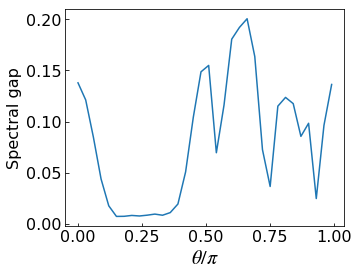

Maximal sgap at 
th=0.6599999999999999pi
  =118.79999999999998(degrees)


In [9]:
# parameters:
rc_bin['2']=30
wells['2']=4
num_pt=34
rc_interval=0.03
coeff['i']=np.zeros(2)

# data:
sgap_arr=np.zeros(num_pt)
i_arr=np.arange(num_pt)
for i in i_arr: 
    th['i'] = np.pi*i*rc_interval
    coeff['i'][0], coeff['i'][1] = np.cos(th['i']), np.sin(th['i'])
    rc['i'] = coeff['i'][0]*x['2'] + coeff['i'][1]*y['2']
    
    pi['i'], _ = stationary(rc['i'], rc_bin=rc_bin['2'])
    MU['i'] = mu_factor(rc['i'], pi['i'], rc_bin=rc_bin['2'], max_d=1)
    S['i'] = sg_transmat(rc_bin['2'], pi['i'], MU['i'], max_d=1)
    sgap_arr[i] = sgap(S['i'], wells['2'])
    
# Plottings:
fig, ax=plt.subplots(figsize=(5,4))
ax.plot(rc_interval*i_arr, sgap_arr)
ax.tick_params(which='major', axis='both', direction='in', labelsize=16)
ax.set_xlabel('$\\theta/\pi$', size=20)
ax.set_ylabel('Spectral gap', size=16)

plt.show()

print('Maximal sgap at \nth={}pi\n  ={}(degrees)'.format(rc_interval*np.argmax(sgap_arr), rc_interval*np.argmax(sgap_arr)*180))

### Exp(eigenvalues) and 0th eigenvectors of MaxCal-based rate matrix for optimal RC $\chi^{(2)}$

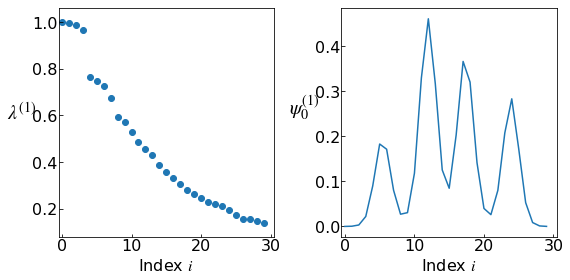

In [10]:
# parameters:
rc_bin['2']=30
th['2']=0.66*np.pi
coeff['2']=np.zeros(2)
coeff['2'][0], coeff['2'][1] = np.cos(th['2']), np.sin(th['2'])

# data:
rc['2'] = coeff['2'][0]*x['2'] + coeff['2'][1]*y['2']
pi['2'], binedges['2'] = stationary(rc['2'], rc_bin=rc_bin['2'])
MU['2'] = mu_factor(rc['2'], pi['2'], rc_bin=rc_bin['2'], max_d=1)
S['2'] = sg_transmat(rc_bin['2'], pi['2'], MU['2'], max_d=1)
E['2'] = eigenval(S['2'])
eval2, exp_eval2, evec2 = E['2']
rate2 = -eval2

# Plottings:
fig, ax=plt.subplots(figsize=(8,4), nrows=1, ncols=2)

ax[0].scatter(np.arange(exp_eval2.shape[0]), exp_eval2)
ax[1].plot(np.abs(evec2[:,0]))

ax[0].tick_params(which='major', axis='both', direction='in', labelsize=16, pad=1)
ax[0].set_xlabel('Index $i$', size=16)
ax[0].set_ylabel('$\lambda^{(1)}$', size=20).set_rotation(0)
ax[0].yaxis.set_label_coords(-0.17, 0.5)
ax[0].set_xlim(-0.5,rc_bin['2']+0.5)

ax[1].tick_params(which='major', axis='both', direction='in', labelsize=16, pad=1)
ax[1].set_xlabel('Index $i$', size=16)
ax[1].set_ylabel('$\psi^{(1)}_0$', size=20).set_rotation(0)
ax[1].yaxis.set_label_coords(-0.17, 0.5)
ax[1].set_xlim(-0.5,rc_bin['2']+0.5)

fig.tight_layout()
plt.show()

### Free energy with $\chi^{(1)}$ and $\chi^{(2)}$

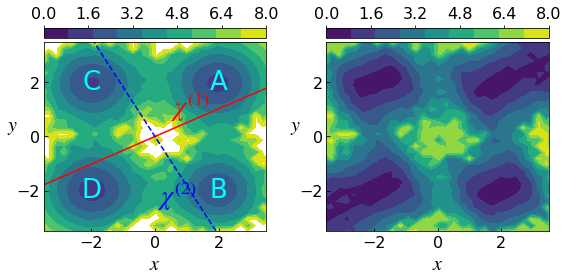

In [11]:
# parameters:
levels=np.linspace(0.0, 8.0, 10)

# data:
hist['rw2d_1']=np.histogram2d(x['2'], y['2'], weights=weights['2'], bins=50)
prob['rw2d_1']=hist['rw2d_1'][0].T/np.sum(hist['rw2d_1'][0].T)
freeE['rw2d_1']=(-1/beta)*np.log(prob['rw2d_1']+1e-9)
mids['rw2d_1']=0.5*(hist['rw2d_1'][1][1:]+hist['rw2d_1'][1][:-1]), 0.5*(hist['rw2d_1'][2][1:]+hist['rw2d_1'][2][:-1])

hist['rw1d_1']=np.histogram(coeff['1'][0]*x['2']+coeff['1'][1]*y['2'], weights=weights['2'], bins=50)
prob['rw1d_1']=hist['rw1d_1'][0].T/np.sum(hist['rw1d_1'][0].T)

hist['rw1d_1'][1][-1]+=1000 # Add 1000 to ensure that the right edge is inclusive.

prob['rw2d_1/rw1d_1']=np.zeros(prob['rw2d_1'].shape)
for i, xi in enumerate(mids['rw2d_1'][0]):     
    for j, yj in enumerate(mids['rw2d_1'][1]): 
        k=np.digitize(coeff['1'][0]*xi+coeff['1'][1]*yj, hist['rw1d_1'][1])-1
        
        # divide the reweighted prob by 1d prob along RC.
        # i=row=y-direction
        # j=column=x-direction
        prob['rw2d_1/rw1d_1'][j,i]=(prob['rw2d_1'][j,i]+1e-9)/(prob['rw1d_1'][k]+1e-9) 

freeE['rw2d_1/rw1d_1']=(-1/beta)*np.log(prob['rw2d_1/rw1d_1']) # reweighted 2d free energy for 2nd component RC.

rc_x=np.linspace(-3.5, 3.5)
rc1_y=np.tan(th['1'])*rc_x
rc2_y=np.tan(th['2'])*rc_x

# Plottings:
fig, ax=plt.subplots(figsize=(8,4), nrows=1, ncols=2)

ctrp = ax[0].contourf(mids['rw2d_1'][0], mids['rw2d_1'][1], freeE['rw2d_1'], levels=levels)

ax[0].text(2.0, 2.0, 'A', horizontalalignment='center', verticalalignment='center', color='cyan', fontsize=26)
ax[0].text(2.0, -2.0, 'B', horizontalalignment='center', verticalalignment='center', color='cyan', fontsize=26)
ax[0].text(-2.0, 2.0, 'C', horizontalalignment='center', verticalalignment='center', color='cyan', fontsize=26)
ax[0].text(-2.0, -2.0, 'D', horizontalalignment='center', verticalalignment='center', color='cyan', fontsize=26)
ax[0].plot(rc_x, rc1_y, 'r-')
ax[0].text(0.5, 0.8, '$\chi^{(1)}$', color='r', fontsize=26)
ax[0].plot(rc_x, rc2_y, 'b--')
ax[0].text(0.1, -2.5, '$\chi^{(2)}$', color='b', fontsize=26)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('top', size='5%', pad='2%')
ticks=np.round(np.linspace(0.0, 8.0 , 6), 1)
cbr = fig.colorbar(ctrp, cax=cax, ticks=ticks, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cbr.ax.tick_params(labelsize=16)

ax[0].tick_params(axis='both', which='major', direction='in', labelsize=16)
ax[0].set_xlabel('$x$', size=20)
ax[0].set_ylabel('$y$', size=20).set_rotation(0)
ax[0].set_xlim(-3.5, 3.5)
ax[0].set_ylim(-3.5, 3.5)

ctrp = ax[1].contourf(mids['rw2d_1'][0], mids['rw2d_1'][1], freeE['rw2d_1/rw1d_1'], levels=levels)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('top', size='5%', pad='2%')
ticks=np.round(np.linspace(0.0, 8.0 , 6), 1)
cbr = fig.colorbar(ctrp, cax=cax, ticks=ticks, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cbr.ax.tick_params(labelsize=16)

ax[1].tick_params(axis='both', which='major', direction='in', labelsize=16)
ax[1].set_xlabel('$x$', size=20)
ax[1].set_ylabel('$y$', size=20).set_rotation(0)
ax[1].set_xlim(-3.5, 3.5)
ax[1].set_ylim(-3.5, 3.5)

fig.tight_layout()
plt.show()

# SGOOP-d

In [12]:
sgd1 = SgoopDistance(coeff['1'], eval1, evec1, binedges['1'])
sgd2 = SgoopDistance(coeff['2'], eval2, evec2, binedges['2'])

def rate1xd(pos1, pos2, K=1, num_eig=rc_bin['1']):
    """
    Calculate rate1 * d_comm.
    """
    d_comm1 = sgd1.pairwise_d(pos1, pos2, num_eig)
    d_comm2 = sgd2.pairwise_d(pos1, pos2, num_eig)
    
    d_hat1 = rate1[1]*d_comm1
    d_hat2 = rate2[1]*d_comm2
    
    return d_hat1 + K*d_hat2


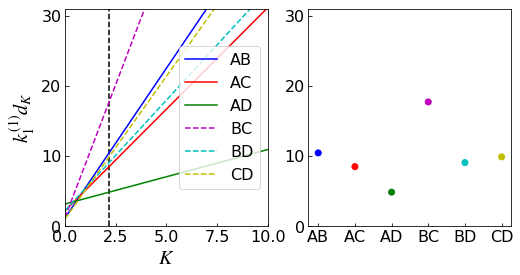

In [13]:
A = (2.0, 2.0)
B = (2.0, -2.0)
C = (-2.0, 2.0)
D = (-2.0, -2.0)

K_ast=rate1[1]/rate2[1]

kd=np.array([rate1xd(A,B, K_ast), rate1xd(A,C, K_ast), rate1xd(A,D, K_ast), 
             rate1xd(B,C, K_ast), rate1xd(B,D, K_ast), rate1xd(C,D, K_ast)])

# Plottings:
K_arr=np.arange(0,50,1)
fig, ax=plt.subplots(figsize=(8,4), nrows=1, ncols=2)
ax[0].plot([K_ast]*3, np.linspace(0,35,3), 'k--')
ax[0].plot(K_arr, rate1xd(A,B,K_arr), 'b-', label='AB')
ax[0].plot(K_arr, rate1xd(A,C,K_arr), 'r-', label='AC')
ax[0].plot(K_arr, rate1xd(A,D,K_arr), 'g-', label='AD')
ax[0].plot(K_arr, rate1xd(B,C,K_arr), 'm--', label='BC')
ax[0].plot(K_arr, rate1xd(B,D,K_arr), 'c--', label='BD')
ax[0].plot(K_arr, rate1xd(C,D,K_arr), 'y--', label='CD')

ax[1].scatter(np.arange(kd.shape[0]), kd, c=['b', 'r', 'g', 'm', 'c', 'y'])

ax[0].tick_params(axis='both', which='major', direction='in', labelsize=16)
ax[0].set_xlabel('$K$', size=20)
ax[0].set_ylabel('$k^{(1)}_1 d_K$', size=20)
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,31)
ax[0].legend(loc='right', fontsize=16)

ax[1].tick_params(which='major', axis='both', direction='in', labelsize=16)
ax[1].set_xticks([0, 1, 2, 3, 4, 5])
labels = [item.get_text() for item in ax[1].get_xticklabels()]
ax[1].set_xticklabels(['AB', 'AC', 'AD', 'BC', 'BD', 'CD'])
ax[1].set_ylim(0,31)

plt.show()

### Convergence of SGOOP-d

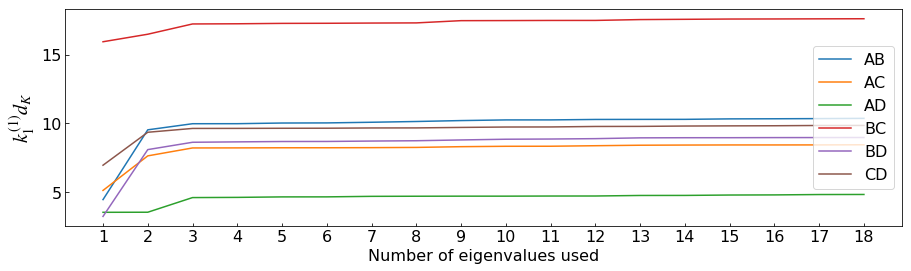

In [14]:
kd_AB=[]
kd_AC=[]
kd_AD=[]
kd_BC=[]
kd_BD=[]
kd_CD=[]

num_eig = np.arange(1,19)
for i in num_eig+1:
    kd_AB.append(rate1xd(A,B, K_ast, i))
    kd_AC.append(rate1xd(A,C, K_ast, i))
    kd_AD.append(rate1xd(A,D, K_ast, i))
    kd_BC.append(rate1xd(B,C, K_ast, i))
    kd_BD.append(rate1xd(B,D, K_ast, i))
    kd_CD.append(rate1xd(C,D, K_ast, i))
    
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=1)

ax.plot(num_eig, kd_AB, label='AB')
ax.plot(num_eig, kd_AC, label='AC')
ax.plot(num_eig, kd_AD, label='AD')
ax.plot(num_eig, kd_BC, label='BC')
ax.plot(num_eig, kd_BD, label='BD')
ax.plot(num_eig, kd_CD, label='CD')

ax.tick_params(axis='both', which='major', direction='in', labelsize=16)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xticks(num_eig)
ax.set_ylabel('$k^{(1)}_1 d_K$', size=20)
ax.set_xlabel('Number of eigenvalues used', size=16)
ax.legend(loc='right', fontsize=16)

plt.show()